In [101]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16, 'font.family': 'serif', 'figure.figsize': (12, 6)})

from scipy.optimize import curve_fit

# read in data
header = ["voltage","current"]
raw_data = np.genfromtxt('lightbulb-data.csv', delimiter=',', skip_header=3, names=header)
voltage = raw_data["voltage"]
current = raw_data["current"]

# sort data by voltage 
sort_index = np.argsort(voltage)
voltage = voltage[sort_index]
current = current[sort_index]

Ideal Power Law
a =  5.161953189155429 +/- 0.013883286409530899
b=0.6
--------------------------------------
I(V) = a*V^b
a =  5.683506739429259 +/- 0.030756931518999563
b =  0.5591789894653963 +/- 0.002284117080850119
--------------------------------------
log(I(V)) = log(a) + b*log(V)
a =  5.714927429208298 +/- 0.03119461500005485
b =  0.556789153331591 +/- 0.0023927242510976524


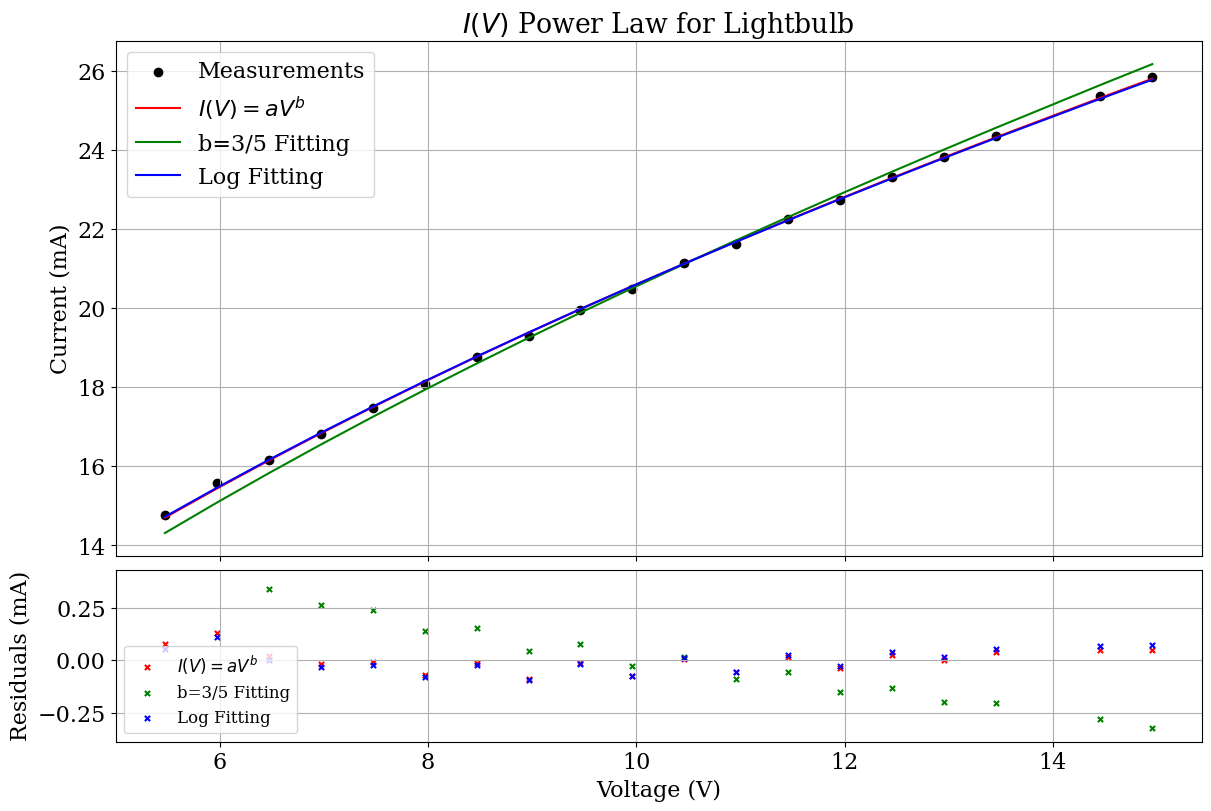

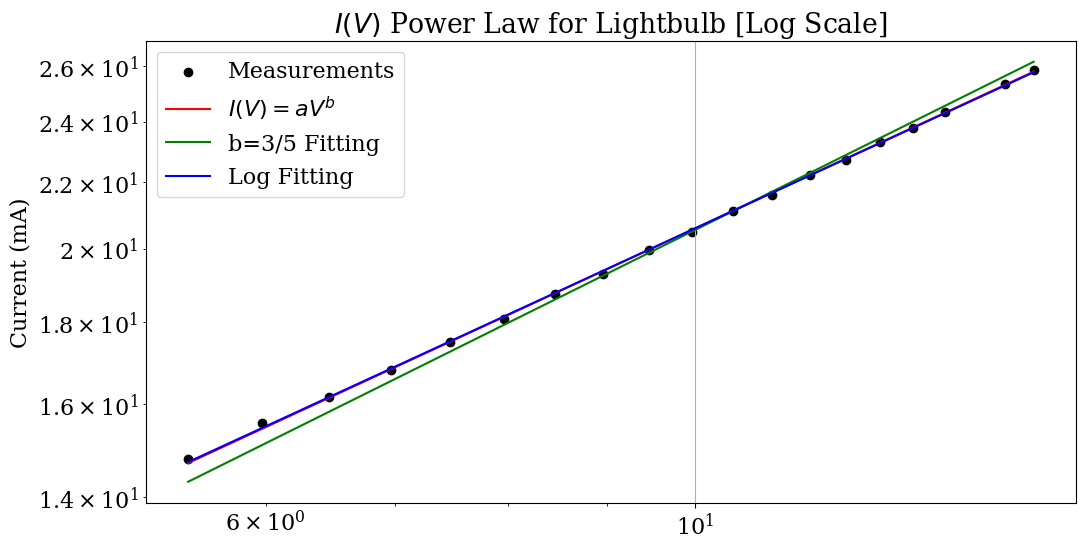

In [102]:
# fit data to power law
def I(V,a,b):
    return a*V**b
def I_ideal(V,a):
    return a*V**(3/5)
def log_I(V,a,b):
    return a+b*V

log_current = np.log(current)
log_voltage = np.log(voltage)

popt, pcov = curve_fit(I, voltage, current)
popt_ideal, pcov_ideal = curve_fit(I_ideal, voltage, current)
popt_log, pcov_log = curve_fit(log_I, log_voltage, log_current)

param_unceratinty = np.sqrt(np.diag(pcov))
param_uncertainty_ideal = np.sqrt(np.diag(pcov_ideal))
param_uncertainty_log = np.sqrt(np.diag(pcov_log))

print("Ideal Power Law")
print("a = ", popt_ideal[0], "+/-", param_uncertainty_ideal[0])
print(f"b={3/5}")
print("--------------------------------------")
print("I(V) = a*V^b")
print("a = ", popt[0], "+/-", param_unceratinty[0])
print("b = ", popt[1], "+/-", param_unceratinty[1])
print("--------------------------------------")
print("log(I(V)) = log(a) + b*log(V)")
print("a = ", np.exp(popt_log[0]), "+/-", param_uncertainty_log[0]*np.exp(popt_log[0]))
print("b = ", popt_log[1], "+/-", param_uncertainty_log[1])


# calcualate residuals and reduced chi^2
def chiSqr(data, model, unc):
    return np.sum((data - model)**2 / unc**2)
def reducedChiSqr(data, model, unc, nParams):
    return chiSqr(data,model,unc) / (len(data) - nParams)

residuals = current - I(voltage, *popt)
residuals_ideal = current - I_ideal(voltage, *popt_ideal)
residuals_log = current - I(voltage, np.exp(popt_log[0]), popt_log[1])

# need to figure out uncertainties for chi^2
# red_chi2 = reducedChiSqr(current, I(voltage, *popt), uncertainty, 2)

# plot fit and residuals
fig, axs = plt.subplots(2,1,layout="constrained",gridspec_kw={'height_ratios': [3, 1]},sharex=True,figsize=(12,8))
plotVals = np.linspace(min(voltage)-1,max(voltage)+1,1000)
axs[0].set_title(r"$I(V)$ Power Law for Lightbulb")
axs[0].scatter(voltage,current,label="Measurements",color="black")
axs[0].plot(voltage,I(voltage,*popt),label=r"$I(V)=aV^b$",color="red")
axs[0].plot(voltage,I_ideal(voltage,*popt_ideal),label="b=3/5 Fitting",color="green")
axs[0].plot(voltage,I(voltage,np.exp(popt_log[0]),popt_log[1]),label="Log Fitting",color="blue")
axs[0].set_ylabel("Current (mA)")
axs[0].legend()
axs[0].grid()
axs[1].scatter(voltage,residuals,label=r"$I(V)=aV^b$",color="red",s=14,marker="x")
axs[1].scatter(voltage,residuals_ideal,label="b=3/5 Fitting",color="green",s=14,marker="x")
axs[1].scatter(voltage,residuals_log,label="Log Fitting",color="blue",s=14,marker="x")
axs[1].set_xlabel("Voltage (V)")
axs[1].set_ylabel("Residuals (mA)")
axs[1].grid()
axs[1].set_ylim(np.min(residuals)-0.3,np.max(residuals)+0.3)
axs[1].legend(fontsize=12,loc="lower left")
plt.show()
fig.savefig("lightbulb_plots.png")

# plot fit and residuals (log scale)
fig = plt.figure(figsize=(12,6))
plotVals = np.linspace(min(voltage)-1,max(voltage)+1,1000)
plt.xscale("log")
plt.yscale("log")
plt.title(r"$I(V)$ Power Law for Lightbulb [Log Scale]")
plt.scatter(voltage,current,label="Measurements",color="black")
plt.plot(voltage,I(voltage,*popt),label=r"$I(V)=aV^b$",color="red")
plt.plot(voltage,I_ideal(voltage,*popt_ideal),label="b=3/5 Fitting",color="green")
plt.plot(voltage,I(voltage,np.exp(popt_log[0]),popt_log[1]),label="Log Fitting",color="blue")
plt.ylabel("Current (mA)")
plt.legend()
plt.grid()
plt.show()
fig.savefig("lightbulb_plots_log.png")